In [1]:
%matplotlib inline
from astropy.table import Table
from tqdm.notebook import tqdm
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

In [2]:
sys.path.append('/home/aalvarez/Work/Projects/Elements/5.8/InstallArea/x86_64-fc31-gcc92-dbg/python/')
sys.path.append('/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/python/')
os.environ['ELEMENTS_AUX_PATH'] = '/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/NNPZ/auxdir/'
os.environ['PATH'] = os.environ['PATH'] + ':/home/aalvarez/Work/Projects/PHZ_NNPZ/PHZ_NNPZ/build.x86_64-fc31-gcc92-dbg/scripts/'

In [3]:
from nnpz.photometry import *
from nnpz.reference_sample.ReferenceSample import ReferenceSample
from nnpz.program import BuildPhotometry

In [4]:
ref_catalog = Table.read('/home/aalvarez/Work/Data/WillHartley/ReferenceSubset.fits')

In [5]:
len(ref_catalog)

400000

In [6]:
class SedProvider(object):
    def __init__(self, basedir):
        self.__basedir = basedir
        self.__cache = dict()
        
    def get_sed(self, name):
        if name not in self.__cache:
            self.__cache[name] = np.genfromtxt(os.path.join(self.__basedir, name))
        return self.__cache[name]

In [7]:
filter_provider = DirectoryFilterProvider('/home/aalvarez/Work/Data/WillHartley/DC3')
sed_provider = SedProvider('/home/aalvarez/Phosphoros/AuxiliaryData/SEDs/')

In [8]:
transmissions = dict()
trans_range = [1e50, -1e50]
for filter_name in filter_provider.getFilterNames():
    print(f'Loading {filter_name}')
    transmissions[filter_name] = filter_provider.getFilterTransmission(filter_name)
    trans_range[0] = np.min([trans_range[0], np.min(transmissions[filter_name][:,0])])
    trans_range[1] = np.max([trans_range[1], np.max(transmissions[filter_name][:,0])])
filters = transmissions.keys()

Loading J
Loading r
Loading z
Loading g
Loading i
Loading Y
Loading u
Loading vis
Loading H


## Group the same SED at different redshifts

In [9]:
recomputed = Table.read('/home/aalvarez/Work/Data/WillHartley/Photometry.fits')
print(len(recomputed))

400000


In [10]:
def get_with_redshift(z):
    i = np.digitize(z, bins=z_edges)
    return 

In [11]:
sed_names = np.unique(ref_catalog['SED_name'])
print(sed_names)

       SED_name       
----------------------
CosmosEll/Ell1_A_0.sed
CosmosEll/Ell2_A_0.sed
CosmosEll/Ell3_A_0.sed
CosmosEll/Ell4_A_0.sed
CosmosEll/Ell5_A_0.sed
CosmosEll/Ell6_A_0.sed
CosmosEll/Ell7_A_0.sed
  CosmosSB/SB0_A_0.sed
 CosmosSB/SB10_A_0.sed
 CosmosSB/SB11_A_0.sed
                   ...
   CosmosSp/Sa_A_0.sed
   CosmosSp/Sa_A_1.sed
   CosmosSp/Sb_A_0.sed
   CosmosSp/Sb_A_1.sed
   CosmosSp/Sc_A_0.sed
   CosmosSp/Sc_A_1.sed
   CosmosSp/Sc_A_2.sed
   CosmosSp/Sd_A_0.sed
   CosmosSp/Sd_A_1.sed
   CosmosSp/Sd_A_2.sed
  CosmosSp/Sdm_A_0.sed
Length = 31 rows


In [12]:
def redshift_sed(sed, z):
    sed = np.copy(sed)
    sed[:, 0] *= (1 + z)
    sed[:, 1] /= (1 + z)**2
    return sed

In [13]:
def plot_sed_and_filters(ax, sed, z):
    sed = redshift_sed(sed, z)
    for f, t in transmissions.items():
        ax.plot(t[:, 0], t[:,1], label=f)
    f = np.logical_and(sed[:,0] >= trans_range[0], sed[:,0] <= trans_range[1])
    sed = sed[f,:].copy()
    sed[:,1] /= np.max(sed[:,1]) / 0.7
    ax.plot(sed[:,0], sed[:,1])
    ax.set_title(f'{z:.3f}')
    ax.legend()

In [14]:
def plot_for_sed(sed_name):
    sed = sed_provider.get_sed(sed_name)
    
    # Get all entries that share the same SED
    same_sed = ref_catalog[ref_catalog['SED_name'] == sed_name]
    nnpz_same_sed = recomputed[ref_catalog['SED_name'] == sed_name]
    
    # Bin redshifts
    z_edges = np.histogram_bin_edges(same_sed['z'], bins=50)
    z_center = (z_edges[1:] + z_edges[:-1]) / 2
    
    # Get the bin corresponding to each object
    object_bin = np.digitize(same_sed['z'], bins=z_edges)
    
    # Plot 6 steps of the redshift
    step = len(z_center) // 6
    zrange = z_center[0:-1:step]
    fig, axes = plt.subplots(ncols=2, nrows=len(zrange), figsize=(25, 10*len(zrange)))
    plt.suptitle(sed_name)

    # For each selected slice
    for i, z in enumerate(zrange):
        # Get those that are within the bin
        bin_idx = np.digitize(z, bins=z_edges)
        selection = object_bin == bin_idx
        shifted, shifted_nnpz = same_sed[selection], nnpz_same_sed[selection]
        
        # Make sure we got the same objects
        assert((shifted['ID'] == shifted_nnpz['ID']).all())

        # Plot filters and shifted SED
        plot_sed_and_filters(axes[i, 0], sed, z)
        for f in transmissions:
            axes[i, 1].scatter(shifted['z'], shifted_nnpz[f'nnpz_{f}']/shifted[f'Flux_{f}'], label=f, marker='.')
        # Plot ratio
        axes[i, 1].plot([np.min(shifted['z']), np.max(shifted['z'])], [1, 1], linestyle='--', c='grey')
        axes[i, 1].plot([z, z], [0.994, 1.003], linestyle='--', c='g')
        axes[i, 1].legend()
    plt.show()
    plt.tight_layout()

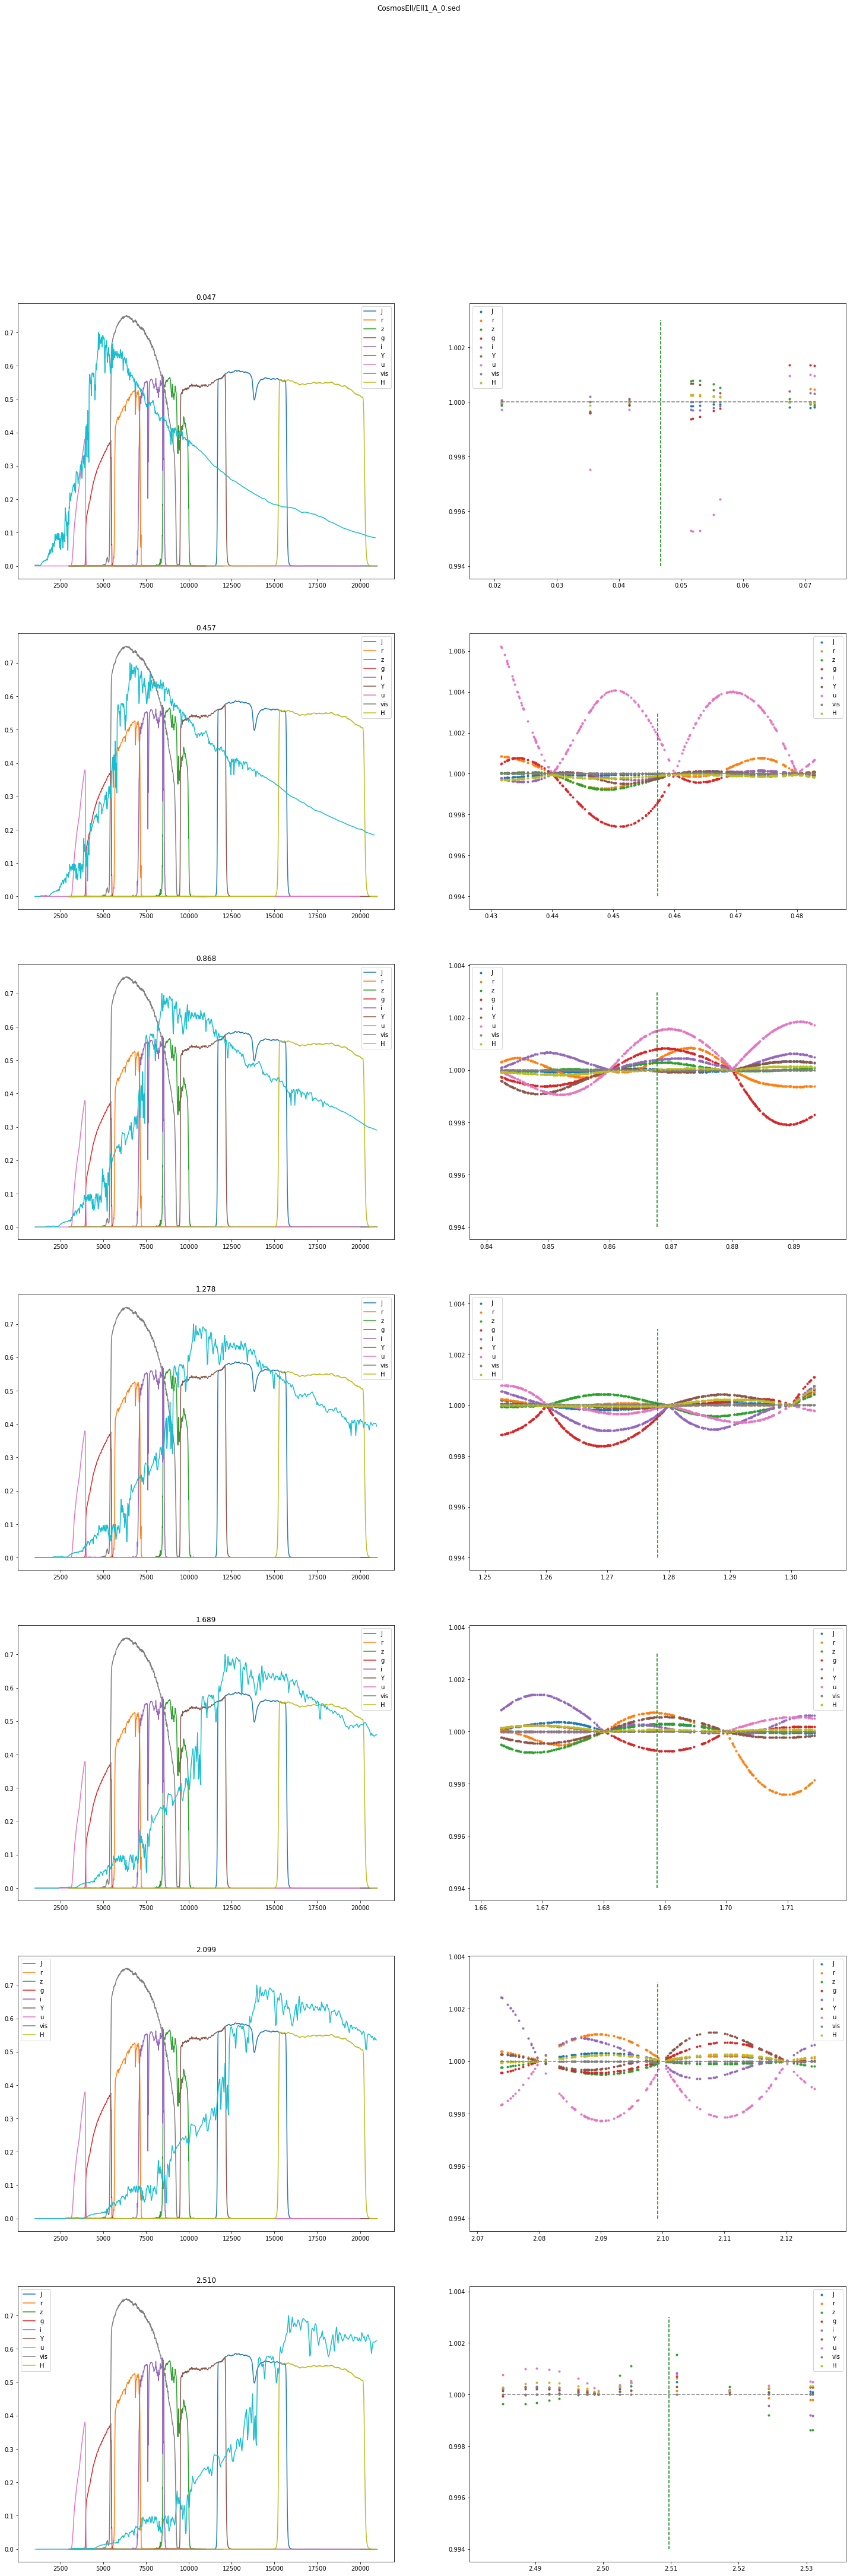

<Figure size 432x288 with 0 Axes>

In [15]:
plot_for_sed(sed_names[0])

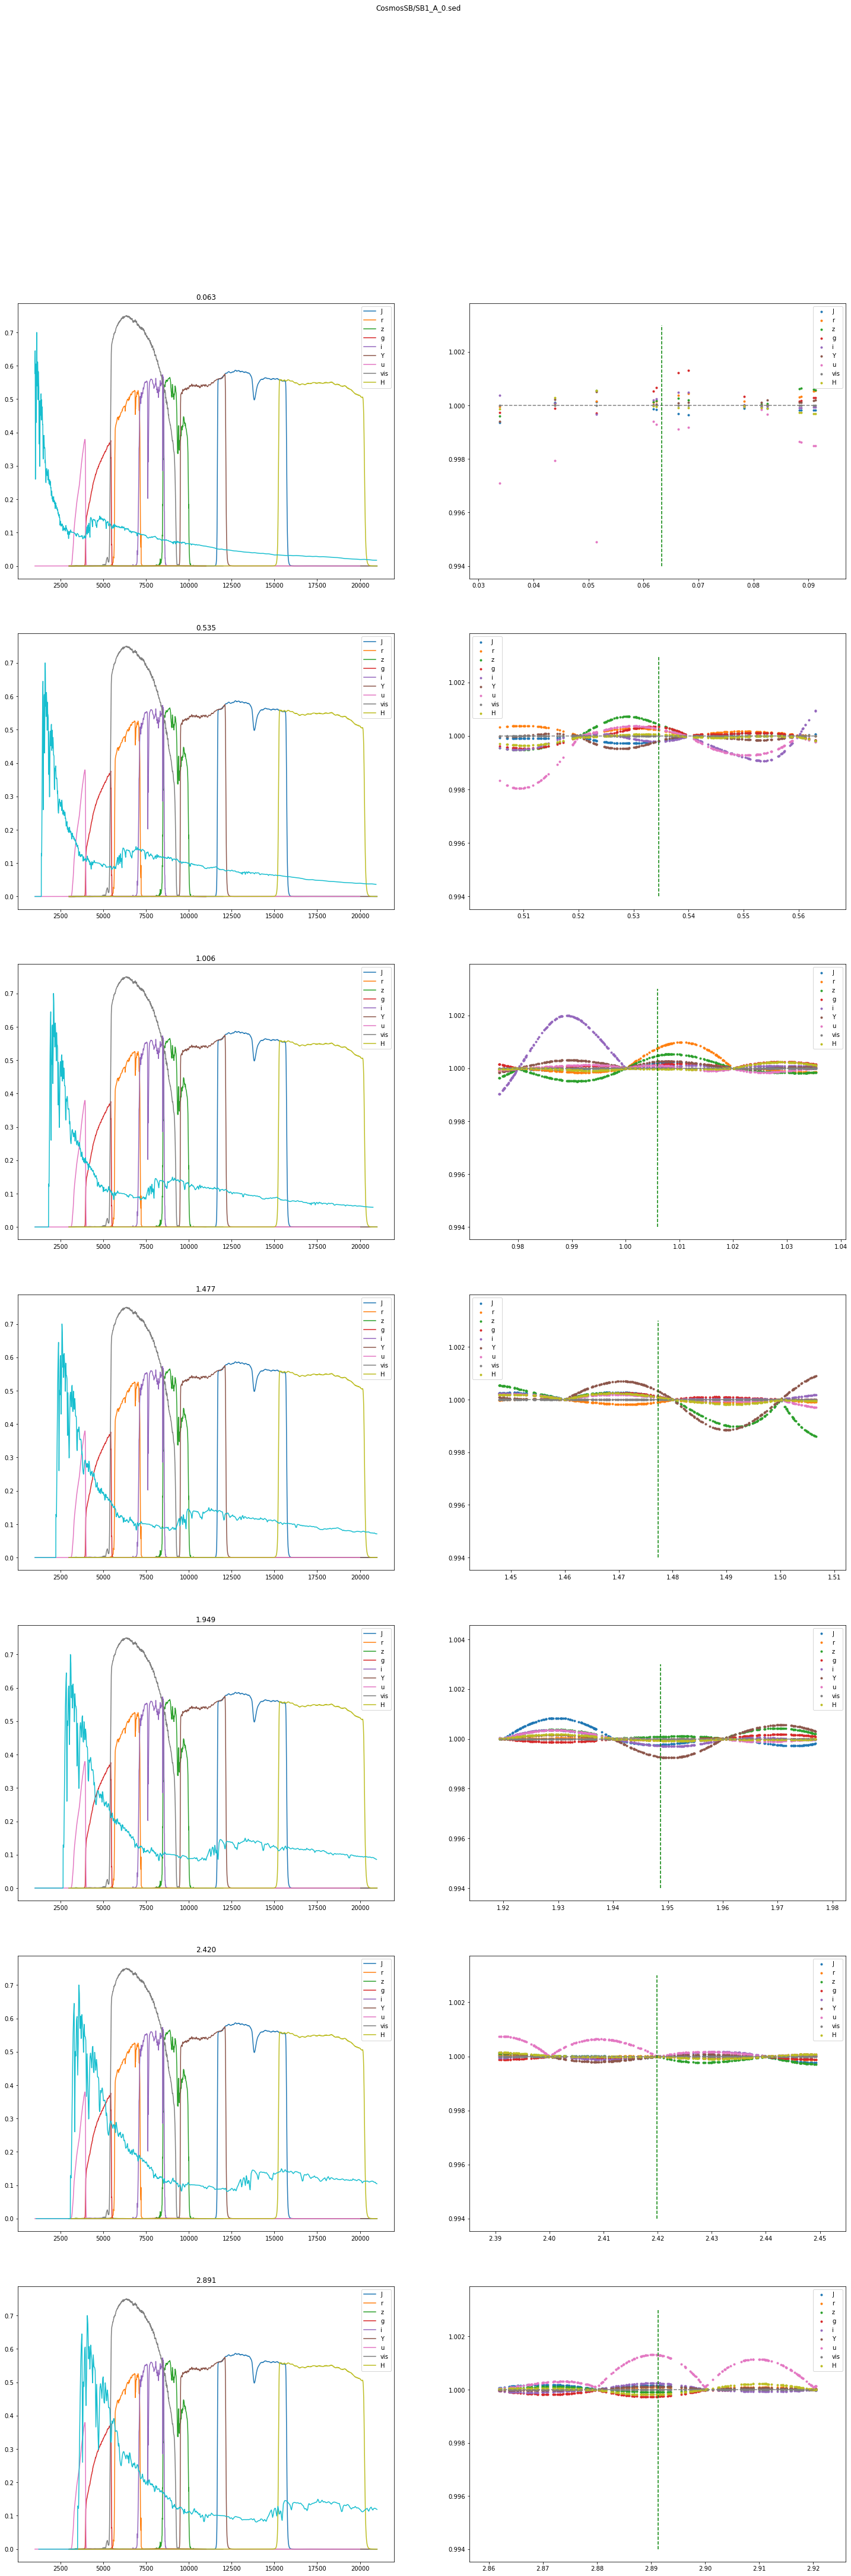

<Figure size 432x288 with 0 Axes>

In [16]:
plot_for_sed(sed_names[10])